# 1. Project Introduction

This project aims to predict the number of daily rides taken each day using Hubway, the bicycle sharing system in the Boston, Massachusetts metro area. The system is owned and operated by the cities of Boston and Cambridge and has changed the transportation landscape in the city. The bikes have become a common feature on the daily commute as well as the weekend adventure. Despite its ubiquitousness, the system still faces many challenges, including more accurate prediction sources for user ease of use, redistribution of bikes when docks become full or empty, and bikeshare availability during the winter. 

Hubway ridership trends depend upon time of day, time of week, seasonality, commute patterns, weather, and holidays. The study begins with scraping relevant ridership datasets from the Hubway Challenge website, the Hubway Tracker, and climatological data for the months January to December of 2016. After some exploratory data analyses, this study explores three predictive algorithms: multiple linear regression, random forest ensemble, and gradient boosting. The study is structured in the following way:

1. Project Introduction
2. Dataset Overview
    - Trips and Station Data
    - Full and Empty Outage Data
    - Bike and Dock Availaility
    - Weather Data
3. Exploratory Data Analysis
    - Outlier Analysis
    - Correlation Analysis
    - Data Visualization
4. Prediction
    - Multiple Regression
    - Random Forest
    - Gradient Boosting
5. Performance

# 2. Dataset Overview

The following data was scraped and collected:

1. Trips and Station Data from the Hubway website
2. Full and Empty outage data from the Hubway Tracker
3. Bike and Dock availability data the Hubway Challenge
4. Weather data from NOAA

Data Fields for EDA and Prediction Modeling:
- weekday: 0 = weekend, 1 = weekday
- season: 0 = winter, 1 = spring, 2 = summer, 3 = fall
- holiday: 0 = no holiday, 1 = holiday
- wind: average daily windspeed (mph)
- snow: snowfall (inches) 
- temp: average hourly temperature (F)
- tmax: highest hourly temperature (F)
- tmin: lowest hourly temperature (F)
- subscriber: number of trips taken by a subscriber
- customer: number of trips taken by a one-time customer
- count: total number of trips taken (dependent variable)

In [516]:
# Import Libraries 

import os
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import collections
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time
from mpl_toolkits.basemap import Basemap
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from math import sqrt

%matplotlib inline

Data Fields:
list them out here at the end...
trips = raw dataframe for exploratory data analysis

trip = hourly dataframe for modeling

weekday: weekday = 1. weekend = 0.
season: winter = 0, spring = 1, summer = 2, fall = 3

# - Trip and Station Data

Hubway has published downloadable files of trip data for each month going back to 2015. According to their website (https://www.thehubway.com/system-data), the data has already been processed to remove trips that are taken by staff as they service the system and any potentially erroneous trips.

This study will focus only on the year 2016. Many non-Cambridge docking stations are shut down for the winter months, so the spring to fall months have more comprehensive coverage. The trip data was extracted from https://s3.amazonaws.com/hubway-data/index.html in .csv files broken out by months. I concatenated the monthly data for 2016 into a single pandas dataframe.

In [172]:
## Snippet to re-run populate "trips" dataframe
trips_path = '/Users/lxu213/data/hubway/Trips_2016/'
trips = pd.DataFrame.from_csv(trips_path + '2016-tripdata.csv', index_col=1)

In [174]:
# include climate day and day of week
climate_path = '/Users/lxu213/data/hubway/Climate_2016.csv'
climate = pd.DataFrame.from_csv(climate_path, index_col=2)
trips['DoW'] = trips.index.dayofweek
trips['day'] = trips.index.date          # add "day" column for sake of joining climate to trips dataframe
climate['day'] = climate.index.date
trips = trips.join(climate.set_index('day').loc[:, ['PRCP','TAVG']], on='day')

In [ ]:
# initial processing of monthly trip files into '2016-tripdata.csv'
# list trip files by monthly data, excluding mac-file .DS_Store 
trip_files = os.listdir(trips_path)[1:]

def concat_trip_data(trips_path, trip_files):
    """ Concatenates all of the monthly hubway trip data of 2016 """
    trips = pd.DataFrame()
    for file in trip_files:
        add_trip = pd.DataFrame.from_csv(trips_path + file)
        trips = trips.append(add_trip)
    return trips

# extract trip data to local
trips = concat_trip_data(trips_path, trip_files)
trips.to_csv('2016-tripdata.csv')

In [5]:
stations = pd.DataFrame.from_csv('/Users/lxu213/data/hubway/Stations_2016.csv', index_col=1)
print 'stations', stations.shape
stations.head()

stations (187, 5)


,Station,Latitude,Longitude,Municipality,# of Docks
Station ID,,,,,
A32000,Fan Pier,42.353287,-71.044389,Boston,15
A32001,Union Square - Brighton Ave. at Cambridge St.,42.353334,-71.137313,Boston,15
A32002,Agganis Arena - 925 Comm Ave.,42.351246,-71.115639,Boston,19
A32003,B.U. Central - 725 Comm. Ave.,42.350406,-71.108279,Boston,11
A32004,Longwood Ave / Binney St,42.338629,-71.106500,Boston,15


# - Station Outage Data

An additional resource provided by the Hubway Challenge is the "Hubway Tracker," which provides real-time station, docking, and a bike availability tool. This tracker is used by Hubway’s Field Operations Managers for dispatch and station rebalancing efforts.

The station outage data was extracted from http://www.hubwaytracker.com/outage_history.php and available as a single downloadable file.

In [ ]:
outages = pd.DataFrame.from_csv(path + 'Outages_2016.csv')
outages.head()

# - Bike and Dock Availability Data

The actual number of available bikes and docks is not available in an easily downloadable format from the Hubway Challenge. However, this data can be scraped and extracted as a JSON via direct HTTP POST requests to http://www.hubwaytracker.com/getstation_json.php.


In [ ]:
# refresh browser, inspect element > network tab > POST > Response 
url = 'http://www.hubwaytracker.com/getstation_json.php'
payload = {'q': 39, 's': '2017-03-26', 'e': '2017-04-02', 
           'wd': 'true', 'we': 'true'}

r = requests.post(url, data=payload).json() 

In [ ]:
# JSON response structure is dict of keys (label, data) and values 
# bad data structure on hubwaytracker. list of tuples of actual data nested very deep. 
# separate API calls for bikes & docks would be better to eliminate need for dict and key-value pair of label-bikes. 

print r[0].keys(), r[0]['label'], type(r[0])  
print r[1].keys(), r[1]['label'], type(r[1])

# structure of JSON dict:
[
    {'label': 'bikes',
     'data': [(1, 2), (3, 5)]
    },
    {'label': 'docks', 
     'data': [(3, 4), (5, 6)]
    }
]

In [ ]:
# extract list of tuples (label: bike)
x = r[0]['data']

# convert epoch to time, x[0] first value of tuple
time = [time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(pair[0])/1000)) for pair in x]

# bikes, x[1] second value of tuple
bikes = [pair[1] for pair in x]

In [ ]:
# merge lists of time and bikes into new tuple
newlist = zip(time, bikes)
print newlist[:10]

# - Climatological Data

Hubway bike usage is highly dependent on climate. The colder and wetter the day, the less inclined a user will be to hop on a bike! Although there are many open-source websites that provide weather and rainfall data, the industry standard for quality rainfall data comes from the National Oceanic and Atmospheric Administration's (formerly the National Climatic Data Center) Quality Controlled Local Climatological Data (QCLCD).

The rainfall data was extracted from https://www.ncdc.noaa.gov/cdo-web/ using the GHCN-Daily CSV format. Great breakdown of the different climatological data sources can be found at http://climate.uaa.alaska.edu/obtaining_data.html.

# 3. Exploratory Data Analysis 

# - Outlier Analysis

Total ridership count contains outliers which skew the distribution towards the right, beyond the outer quartile limit. There are a few days with extremely high ride count. The boxplots below also show that winter has relatively fewer rides and proportionally fewer outliers as well. 

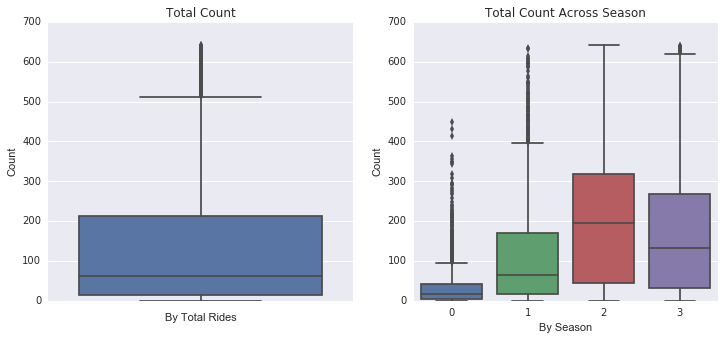

In [635]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.boxplot(data=trip,y="count",orient="v",ax=axes[0])
sns.boxplot(data=trip,y="count",x="season",orient="v",ax=axes[1])

axes[0].set(xlabel='By Total Rides', ylabel='Count',title="Total Count")
axes[1].set(xlabel='By Season', ylabel='Count',title="Total Count Across Season")

# - Correlation Analysis

In [636]:
# remove outliers
print 'With Outliers:', trip.shape
trip = trip[np.abs(trip['count']-trip['count'].mean())<=(3*trip['count'].std())] 
print 'Without Outliers:', trip.shape

With Outliers: (8615, 14)
Without Outliers: (8497, 14)


Correlation matrix can help illustrate how much a dependent variable is influenced by certain numerical features. Rain, wind, and snow are only slightly negatively correlated with the number of trips taken. Regression plots can help depict the relationship between two features.  

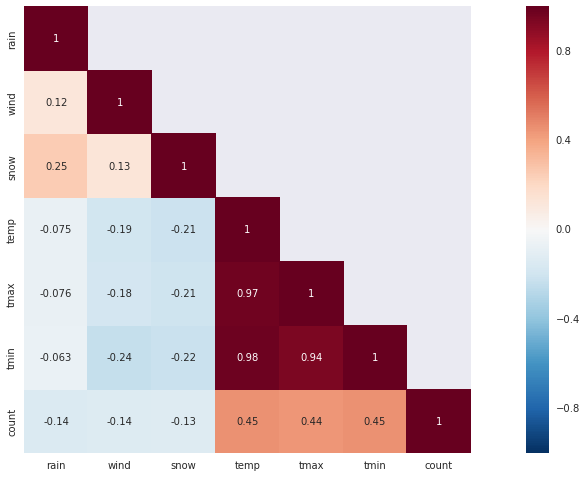

In [637]:
# Correlation Analysis
corr_fields = trip[['rain', 'wind', 'snow', 'temp', 'tmax', 'tmin', 'count']].corr()
mask = np.array(corr_fields)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(20,8))
sns.heatmap(corr_fields, mask=mask, square=True, annot=True)

(-5, 10)

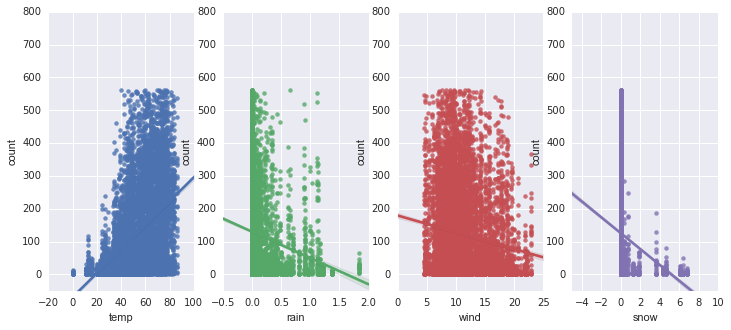

In [639]:
# regression plots
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=trip[:-1],ax=ax1)
sns.regplot(x="rain", y="count", data=trip,ax=ax2)
sns.regplot(x="wind", y="count", data=trip,ax=ax3)
sns.regplot(x="snow", y="count", data=trip,ax=ax4)
ax1.set_ylim(-50,800)
ax2.set_ylim(-50,800)
ax3.set_ylim(-50,800)
ax4.set_ylim(-50,800)
ax4.set_xlim(-5,10)

# - Data Visualization 

Visualize Hubway ridership statistics by time of day, time of week, seasonality, gender, age, geographic distribution, and commuter patterns to better understand the data.

Gender Distribution
Female: 18.8 %
Male: 61.1 %
Unregistered: 20.1 %


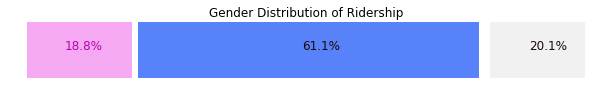

In [80]:
# Gender
tot_trips = trips['bikeid'].count() *1.0         # 1.2M

gender_breakdown = trips.groupby('gender')['bikeid'].count()
perc_fem = round(gender_breakdown[0]/tot_trips, 3) *100
perc_male = round(gender_breakdown[1]/tot_trips, 3) *100
perc_unreg = round(gender_breakdown[2]/tot_trips, 3) *100

print 'Gender Distribution'
print 'Female:', perc_fem, '%'
print 'Male:', perc_male, '%'
print 'Unregistered:', perc_unreg, '%'

# plot gender breakdown in single horizontal bar
plt.figure(figsize=(10,1));
ax = plt.gca();
plt.axis('off');
ax.patch.set_visible(False);
plt.plot([0, perc_fem], [5, 5], linewidth=100, 
         linestyle="-", c="#F5A9F2", solid_capstyle="butt");
plt.plot([perc_fem+1, 1+perc_male+perc_fem], [5, 5], linewidth=100, 
         linestyle="-", color='#5882FA',solid_capstyle="butt");  
plt.plot([3+perc_fem+perc_male, perc_male+perc_fem+perc_unreg], [5, 5], 
         linewidth=100, linestyle="-", c='#F1F1F1',solid_capstyle="butt")
plt.title('Gender Distribution of Ridership');

# annotate with percentages
plt.annotate(str(perc_fem)+"%", xy=(perc_unreg/3,5),size=12, color='#B404AE')   
plt.annotate(str(perc_male)+"%", xy=(perc_fem+perc_male/2,5.0),size=12, color='#190707')
plt.annotate(str(perc_unreg)+"%", xy=(perc_fem+perc_male+perc_unreg/2,5.0),size=12,color='#190707');       

Total Customer Trips: 252261.0
Total Subscriber Trips: 983938.0
 
Type = Customer
Female: 81.6 %
Male: 14.2 %
Unregistered: 4.3 %

Type = Subscriber
Female: 2.7 %
Male: 73.1 %
Unregistered: 24.2 %



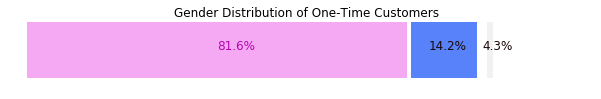

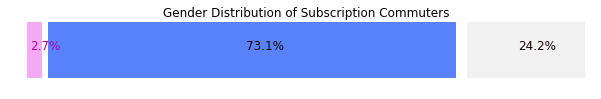

In [81]:
# Rider type: one-time customer or commuting subscriber 
tot_customer_trips = trips.loc[trips['usertype'] == 'Customer']['bikeid'].count() *1.0         # 250k
tot_subscriber_trips = trips.loc[trips['usertype'] == 'Subscriber']['bikeid'].count() *1.0     # 980k
print 'Total Customer Trips:', tot_customer_trips
print 'Total Subscriber Trips:', tot_subscriber_trips
print ' '

gender_by_user_type = trips.groupby(['usertype','gender'])['bikeid'].count()
gender_customer = gender_by_user_type['Customer']
gender_subscriber = gender_by_user_type['Subscriber']

# Customer data
perc_fem_c = round(gender_customer[0]/tot_customer_trips, 3) *100
perc_male_c = round(gender_customer[1]/tot_customer_trips, 3) *100
perc_unreg_c = round(gender_customer[2]/tot_customer_trips, 3) *100

print 'Type = Customer'
print 'Female:', perc_fem_c, '%'
print 'Male:', perc_male_c, '%'
print 'Unregistered:', perc_unreg_c, '%'
print ''

# Subscriber data
perc_fem_s = round(gender_subscriber[0]/tot_subscriber_trips, 3) *100
perc_male_s = round(gender_subscriber[1]/tot_subscriber_trips, 3) *100
perc_unreg_s = round(gender_subscriber[2]/tot_subscriber_trips, 3) *100

print 'Type = Subscriber'
print 'Female:', perc_fem_s, '%'
print 'Male:', perc_male_s, '%'
print 'Unregistered:', perc_unreg_s, '%'

# Customers: plot gender breakdown in single horizontal bar
plt.figure(figsize=(10,1));
ax = plt.gca();
plt.axis('off');
ax.patch.set_visible(False);
plt.plot([0, perc_fem_c], [5, 5], linewidth=100, 
         linestyle="-", c="#F5A9F2", solid_capstyle="butt");
plt.plot([perc_fem_c+1, 1+perc_male_c+perc_fem_c], [5, 5], linewidth=100, 
         linestyle="-", c='#5882FA',solid_capstyle="butt");
plt.plot([3+perc_fem_c+perc_male_c, perc_male_c+perc_fem_c+perc_unreg_c], [5, 5], 
         linewidth=100, linestyle="-", c='#F1F1F1',solid_capstyle="butt")
print ''
plt.title('Gender Distribution of One-Time Customers');

# annotate with percentages
plt.annotate(str(perc_fem_c)+"%", xy=(perc_fem_c/2,5),size=12, color='#B404AE')   
plt.annotate(str(perc_male_c)+"%", xy=(perc_fem_c+perc_male_c/3,5.0),size=12, color='#190707')
plt.annotate(str(perc_unreg_c)+"%", xy=(perc_fem_c+perc_male_c+perc_unreg_c/2,5.0),size=12,color='#190707');   

# Subscribers: plot gender breakdown in single horizontal bar
plt.figure(figsize=(10,1));
ax = plt.gca();
plt.axis('off');                                           # axis not necessary for clean bar look
ax.patch.set_visible(False);
plt.plot([0, perc_fem_s], [5, 5], linewidth=100,           # start stop axis at beg/end of each perc_X
         linestyle="-", c="#F5A9F2", solid_capstyle="butt");
plt.plot([perc_fem_s+1, 1+perc_male_s+perc_fem_s], [5, 5], linewidth=100, 
         linestyle="-", c='#5882FA',solid_capstyle="butt");
plt.plot([3+perc_fem_s+perc_male_s, perc_male_s+perc_fem_s+perc_unreg_s], [5, 5], 
         linewidth=100, linestyle="-", c='#F1F1F1',solid_capstyle="butt")
plt.title('Gender Distribution of Subscription Commuters');

# annotate with percentages
plt.annotate(str(perc_fem_s)+"%", xy=(perc_fem_s/5,5),size=12, color='#B404AE')   
plt.annotate(str(perc_male_s)+"%", xy=(perc_fem_s+perc_male_s/2,5.0),size=12, color='#190707')
plt.annotate(str(perc_unreg_s)+"%", xy=(perc_fem_s+perc_male_s+perc_unreg_s/2,5.0),size=12,color='#190707');  

In [59]:
# Age
birth = trips.groupby('birth year')['bikeid'].count()
birth = birth[:-1]                                   # last entry is N/A
age = [2018 - int(x) for x in birth.index]           # convert birth year to age 

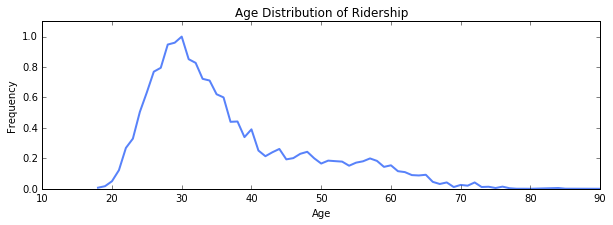

In [73]:
# plot age
plt.figure(figsize=(10,3))
ax = plt.gca()
ax.set_xlim(10, 90)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
ax.set_title('Age Distribution of Ridership')
plt.plot(age, birth/max(birth), linestyle="-", linewidth='2', color='#5882FA');      # calculate frequency by normalizing birth

In [53]:
# Time of Day of Rides
trips_wdy = trips.loc[trips['DoW'].isin([0,1,2,3,4])]    # 963,474
trips_wkd = trips.loc[trips['DoW'].isin([5,6])]          # 272,725

hourly_wdy = trips_wdy.index.hour
hourly_wkd = trips_wkd.index.hour

hour_freq_wdy = collections.Counter(hourly_wdy)          # count frequency of hour values
hour_freq_wkd = collections.Counter(hourly_wkd) 
type(hour_freq_wdy)

collections.Counter

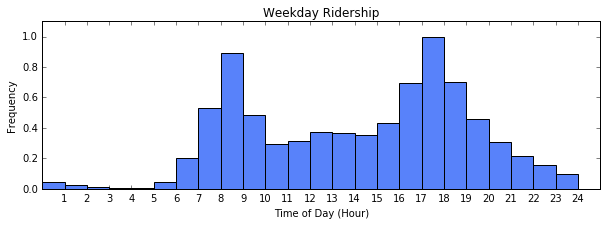

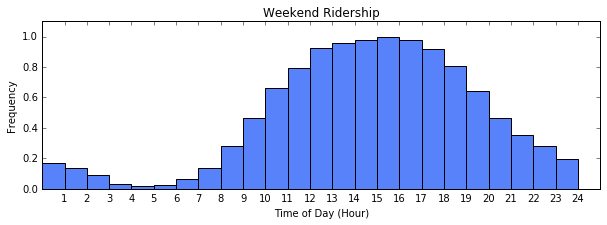

In [71]:
# weekday
hour, freq = zip(*hour_freq_wdy.items())       # unzip key & freq from collections.Counter, outputs tuples
freq = [float(x)/max(freq) for x in freq]      # normalize frequency 

# plot type(collections.Counter)
plt.figure(figsize=(10,3))
ax = plt.gca()
width = 1
plt.bar(hour, freq, width, color='#5882FA')
plt.xticks(np.arange(len(hour))+1)             # convert hour tuple to np.array for plotting xtick labels
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time of Day (Hour)')
ax.set_ylabel('Frequency')
ax.set_title('Weekday Ridership')
plt.show();

# weekend
hour, freq = zip(*hour_freq_wkd.items())       # unzip key & freq from collections.Counter, outputs tuples
freq = [float(x)/max(freq) for x in freq]      # normalize frequency 

# plot type(collections.Counter)
plt.figure(figsize=(10,3))
ax = plt.gca()
width = 1
plt.bar(hour, freq, width, color='#5882FA')
plt.xticks(np.arange(len(hour))+1)             # convert hour tuple to np.array for plotting xtick labels
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time of Day (Hour)')
ax.set_ylabel('Frequency')
ax.set_title('Weekend Ridership')
plt.show();

In [86]:
## Climate
# add "day" column for sake of joining climate to trips dataframe
trips['day'] = trips.index.date
climate['day'] = climate.index.date

# add only precip and temp
# join on climate's 'day' col and trip's 'day col
trips = trips.join(climate.set_index('day').loc[:, ['PRCP','TAVG']], on='day')

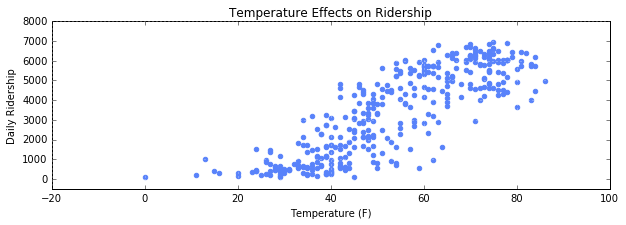

In [89]:
daily_ridership = trips.groupby('day')['bikeid'].count()

# plot trip vs. temperature
plt.figure(figsize=(10,3))
ax = plt.gca()
ax.grid(b=None, color='w')
ax.set_ylim(-500, 8000)
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Daily Ridership')
ax.set_title('Temperature Effects on Ridership')
plt.scatter(climate['TAVG'], daily_ridership, marker='o', color='#5882FA');

In [164]:
# Rain

# Time of Day of Rides for Rainy Days
trips_wdy_rain = trips.loc[(trips['DoW'].isin([0,1,2,3,4])) & trips['PRCP'] != 0]    # 233,530
trips_wkd_rain = trips.loc[(trips['DoW'].isin([5,6])) & trips['PRCP'] != 0]          #  74,606
hourly_wdy_rain = trips_wdy_rain.index.hour
hourly_wkd_rain = trips_wkd_rain.index.hour
hour_freq_wdy_rain = collections.Counter(hourly_wdy_rain)        # count frequency of hour values
hour_freq_wkd_rain = collections.Counter(hourly_wkd_rain) 

# Time of Day of Rides for Non-Rainy Days
trips_wdy_norain = trips.loc[(trips['DoW'].isin([0,1,2,3,4])) & trips['PRCP'] == 0]  # 1,002,669
trips_wkd_norain = trips.loc[(trips['DoW'].isin([5,6])) & (trips['PRCP'] == 0)]      #   198,119
hourly_wdy_norain = trips_wdy_norain.index.hour
hourly_wkd_norain = trips_wkd_norain.index.hour
hour_freq_wdy_norain = collections.Counter(hourly_wdy_norain)        # count frequency of hour values
hour_freq_wkd_norain = collections.Counter(hourly_wkd_norain) 


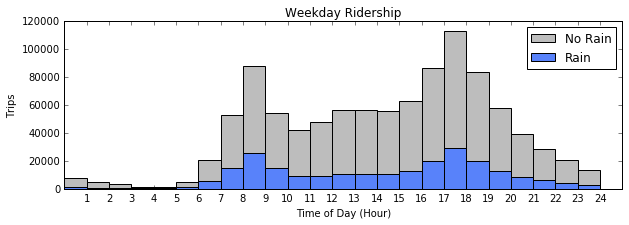

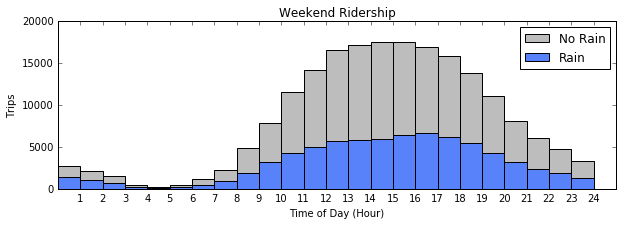

In [166]:
# Plot Weekday
hour, freq_wdy_rain = zip(*hour_freq_wdy_rain.items())            # unzip key freq counts from collections.Counter
hour, freq_wdy_norain = zip(*hour_freq_wdy_norain.items())    

# plot type(collections.Counter)
plt.figure(figsize=(10,3))
ax = plt.gca()
width = 1
p1 = plt.bar(hour, freq_wdy_norain, width, color='#BDBDBD')
p2 = plt.bar(hour, freq_wdy_rain, width, color='#5882FA')
plt.xticks(np.arange(len(hour))+1)         
ax.set_xlabel('Time of Day (Hour)')
ax.set_ylabel('Trips')
ax.set_title('Weekday Ridership')
plt.legend((p1[0], p2[0]), ('No Rain', 'Rain'))
plt.show();

# Plot Weekend
hour, freq_wkd_rain = zip(*hour_freq_wkd_rain.items())            # unzip key freq counts from collections.Counter
hour, freq_wkd_norain = zip(*hour_freq_wkd_norain.items())    

# plot type(collections.Counter)
plt.figure(figsize=(10,3))
ax = plt.gca()
width = 1
p1 = plt.bar(hour, freq_wkd_norain, width, color='#BDBDBD')
p2 = plt.bar(hour, freq_wkd_rain, width, color='#5882FA')
plt.xticks(np.arange(len(hour))+1)         
ax.set_ylim(0, 20000)
ax.set_xlabel('Time of Day (Hour)')
ax.set_ylabel('Trips')
ax.set_title('Weekend Ridership')
plt.legend((p1[0], p2[0]), ('No Rain', 'Rain'))
plt.show();

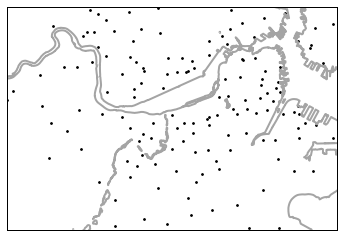

In [43]:
# Geographic Distribution of Stations
# Documentation found here = https://matplotlib.org/basemap/api/basemap_api.html
path_shp = '/Users/lxu213/data/hubway/shapefile/Hydrography_Polygon'

# plot basemap using mercator projection and set lat/long boundaries 
m = Basemap(projection='merc', llcrnrlon=-71.15, llcrnrlat=42.32, urcrnrlon=-71.03, urcrnrlat=42.38, resolution='c')

# read in hydrography shapefile from Analyze Boston
# https://data.boston.gov/dataset/hydrography-polygon
m.readshapefile(path_shp, 'Hydrography_Polygon', drawbounds=True, linewidth=2, color='#A4A4A4') 
lats = stations['Latitude'].tolist()               # scatter plot requires list input (not Series)
lons = stations['Longitude'].tolist()
m.scatter(lons, lats, 3, marker='o', color='k', latlon=True)
plt.show()

# 4. Predictions

In [ ]:
## Build dataset for prediction models
trips_path = '/Users/lxu213/data/hubway/Trips_2016/'
trips = pd.DataFrame.from_csv(trips_path + '2016-tripdata.csv', index_col=1)

In [274]:
# Data processing to prepare for prediction models
# eliminate categorical features using one-hot encoding (dummy variables) 

# subscriber, customer, and total ridership
trip = trips.loc[:, ['usertype']]
trip = trip.rename(columns={'usertype': 'subscriber'})
trip['customer'] = pd.Series(trip['subscriber'], index=trip.index)
trip['count'] = pd.Series(1, index=trip.index)

def convert_subscriber(row):
    return 1 if row == 'Subscriber' else 0
def convert_customer(row):
    return 1 if row == 'Customer' else 0

trip['subscriber'] = trip['subscriber'].apply(lambda row: convert_subscriber(row))  # apply function down rows
trip['customer'] = trip['customer'].apply(lambda row: convert_customer(row))

trip = trip.resample('1H', how='sum')        # sample series into 1 hour bins, sum count into bins
trip = trip.fillna(0)                        # fill hours with no rides

# add day of week, hour, month
def convert_weekday(row):
    return 1 if row in (0,1,2,3,4) else 0
trip['weekday'] = pd.Series(trip.index.dayofweek, index=trip.index)
trip['weekday'] = trip['weekday'].apply(lambda row: convert_weekday(row))
trip['hour'] = trip.index.hour
trip['month'] = trip.index.month

# add season
def is_season(row):
    if row in (12,1,2):
        return 0
    if row in (3,4,5):
        return 1
    if row in (6,7,8):
        return 2
    else:
        return 3
trip['season'] = pd.Series(trip.index.month, index=trip.index)
trip['season'] = trip['season'].apply(lambda row: is_season(row))

# holiday
holidays = calendar().holidays(start='2016-01-01', end='2016-12-31').to_pydatetime()
def is_holiday(row):
    return 1 if row in holidays else 0
trip['holiday'] = pd.Series(trip.index, index=trip.index)   
trip['holiday'] = trip['holiday'].apply(lambda row: is_holiday(row))

,weekday,hour,month,season,holiday,rain,wind,snow,temp,tmax,tmin,subscriber,customer,count
starttime,,,,,,,,,,,,,,
2016-01-01 00:00:00,1,0,1,0,1,0,12.75,0,39,41,33,12,1,13
2016-01-01 01:00:00,1,1,1,0,0,0,12.75,0,39,41,33,10,4,14
2016-01-01 02:00:00,1,2,1,0,0,0,12.75,0,39,41,33,8,1,9
2016-01-01 03:00:00,1,3,1,0,0,0,12.75,0,39,41,33,1,0,1
2016-01-01 04:00:00,1,4,1,0,0,0,12.75,0,39,41,33,0,0,0


In [ ]:
# join climate data: rain, snow, temp
climate = pd.DataFrame.from_csv('/Users/lxu213/data/hubway/Climate_2016.csv', index_col=2)
climate_features = ['PRCP', 'AWND', 'SNOW', 'TAVG', 'TMAX', 'TMIN']
trip = trip.join(climate.set_index(climate.index.date).loc[:, climate_features], on=trip.index.date)
trip = trip.rename(columns={'PRCP': 'rain', 'AWND': 'wind', 'SNOW': 'snow', 
                            'TAVG': 'temp', 'TMAX': 'tmax', 'TMIN': 'tmin'})

# rearranging columns of dataframe
cols = trip.columns.tolist()
cols = cols[3:] + cols[:3]
trip = trip[cols]
trip[:5]

# - Linear Regression Model

In [502]:
# root mean squared log error function from viveksrinivasan
# kaggle notebook: eda-ensemble-model-top-10-percentile

def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [612]:
# split data into train (60%), validate (20%), test (20%) sets
train, validate, test = np.split(trip.sample(frac=1), [int(.6*len(trip)), int(.8*len(trip))])

features = ['hour','weekday','month','season','holiday','rain','wind','snow','temp']
train_set = train[features]         
train_target = train['count']
test_set = test[features]
test_target = test['count']
val_set = validate[features]
val_target = validate['count']

In [618]:
# prediction and scoring
l_model = LinearRegression()                        # initialize
l_model.fit(X=train_set, y=train_target)            # fit linear model using train set+target
preds = l_model.predict(test_set)                   # predict using test set
l_coeff = 'Coefficients:', [l_model.coef_]
l_preds = preds

print 'MSE:', round(mean_squared_error(test_target, preds), 2)
print 'RMSE:', round(sqrt(mean_squared_error(test_target, preds)), 2)
print 'RMSLE:', round(rmsle(test_target, preds, False), 2)
print 'R^2 (test):', round(l_model.score(test_set, test_target), 3)  # r2_score(test_target, preds)
print 'R^2 (validation):', round(l_model.score(val_set, val_target), 3) 

MSE: 13726.03
RMSE: 117.16
RMSLE: 1.41
R^2 (test): 0.347
R^2 (validation): 0.329


Modeling ridership in linear space yields a model with estimates that are way off. Linear modeling yields a pretty low R^2, which is the proportion of the variance in the dependent variable that is predictable from the independent variables, the feature set. A good model will have a R^2 close to 1. The ridership target variable clearly has a non-linear relationship with the selected input feature set. 

This can be verified by examining the linear model's residuals, the difference between actual number of ridership and the predicted. A good model will have residuals that are small in absolute value and evenly distributed  around the true values. The residual analysis shows that the predictions are often extremely off (high absolute values up to 400) and consistently over predict number of rides taken.

If the R2 is ever much better for the training data than for the validation data, it is a sign that the model is overfitted. Additional metrics are mean squared error, which measures the average of the squares of the errors, and root mean square error, which represents the sample standard deviation of the differences between predicted values and observed values.

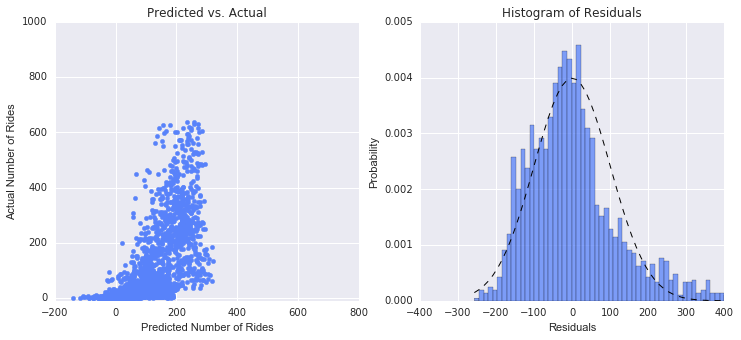

In [601]:
residuals = test_target - preds
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
ax = plt.gca()

# scatter plot of actual vs. predicted
ax1.scatter(preds, test_target, marker='o', color = '#5882FA')
ax1.set_xlim(-200, 800)
ax1.set_ylim(-10, 1000)
ax1.set_xlabel('Predicted Number of Rides')
ax1.set_ylabel('Actual Number of Rides')
ax1.set_title('Predicted vs. Actual')

# histogram of residuals
n, bins, patches = plt.hist(residuals, bins=60, normed=1, facecolor='#5882FA', alpha=0.75)
mu, sigma = 0, 100                              # add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'k--', linewidth=1)
ax2.set_xlim(-400, 400)
plt.xlabel('Residuals')
plt.ylabel('Probability')
plt.title('Histogram of Residuals')

plt.show()

# Random Forest Ensemble Model

Random forest is an ensemble learning method that averages multiple deep decision trees. The training algorithm uses bootstrap aggregation, or bagging, by selecting a random sample of the training set and fits individual trees according to this sample of features. Using multiple decision trees corrects for a single decision trees' tendency to be overfitted, while bootstrapping increases model performance by decreasing the variance of the model, without increasing the bias. Predictions of a single tree are highly sensitive to noise in its training set, while the average of many trees is not.

My favorite explanation for random forest using movie suggestions from a friend: https://www.quora.com/How-does-randomization-in-a-random-forest-workThe 

In [619]:
rf_model = RandomForestRegressor(n_estimators=100)          # estimators = number of trees   
rf_model.fit(train_set, train_target)
preds = rf_model.predict(X= test_set)
rf_preds = preds

print 'MSE:', round(mean_squared_error(test_target, preds), 2)
print 'RMSE:', round(sqrt(mean_squared_error(test_target, preds)), 2)
print 'RMSLE:', round(rmsle(test_target, preds, False), 2)
print 'R^2 (test):', round(rf_model.score(test_set, test_target), 3)  # r2_score(test_target, preds)
print 'R^2 (validation):', round(rf_model.score(val_set, val_target), 3) 

MSE: 1500.46
RMSE: 38.74
RMSLE: 0.46
R^2 (test): 0.929
R^2 (validation): 0.94


In [611]:
rf_model = RandomForestRegressor(n_estimators=100)          # estimators = number of trees   
rf_model.fit(train_set, train_target)
preds = rf_model.predict(X= test_set)

print 'MSE:', round(mean_squared_error(test_target, preds), 2)
print 'RMSE:', round(sqrt(mean_squared_error(test_target, preds)), 2)
print 'RMSLE:', round(rmsle(test_target, preds, False), 2)
print 'R^2 (test):', round(rf_model.score(test_set, test_target), 3)  # r2_score(test_target, preds)
print 'R^2 (validation):', round(rf_model.score(val_set, val_target), 3) 

MSE: 1439.99
RMSE: 37.95
RMSLE: 0.46
R^2 (test): 0.935
R^2 (validation): 0.935


This ensemble model performs much better than the linear regression model. R^2 is fairly high, indicating a higher proportion of ridership variance is predictable from the feature set using this ensemble model.  

The residuals are smaller in absolute value and relatively evenly distributed around the true values. The residual analysis shows that the predictions are relatively consistent with the actual number of rides taken.

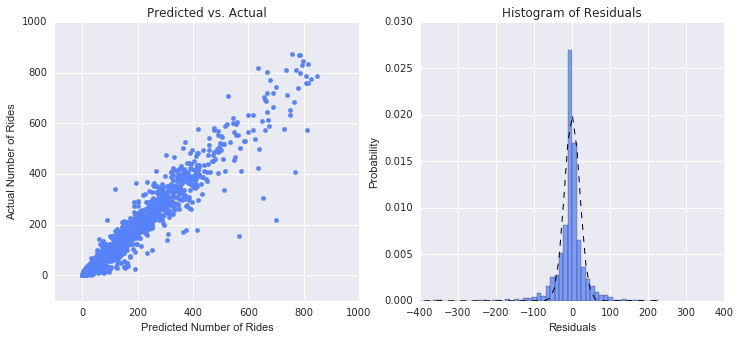

In [535]:
residuals = test_target - preds
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
ax = plt.gca()

# scatter plot of actual vs. predicted
ax1.scatter(preds, test_target, marker='o', color = '#5882FA')
ax1.set_xlim(-100, 1000)
ax1.set_ylim(-100, 1000)
ax1.set_xlabel('Predicted Number of Rides')
ax1.set_ylabel('Actual Number of Rides')
ax1.set_title('Predicted vs. Actual')

# histogram of residuals
n, bins, patches = plt.hist(residuals, bins=60, normed=1, facecolor='#5882FA', alpha=0.75)
mu, sigma = 0, 20                              # add a 'best fit' line
ax2.set_xlim(-400, 400)
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'k--', linewidth=1)

plt.xlabel('Residuals')
plt.ylabel('Probability')
plt.title('Histogram of Residuals')

plt.show()

# Gradient Boosting Ensemble Model

Gradient Boosting forms a prediction based on an ensemble of weak prediction models, usually individual decision trees. The model is constructed in a stage-wise fashion and generalizes the trees by allowing optimization of an arbitrary differentiable loss function.

Read more here: https://gormanalysis.com/gradient-boosting-explained/

In [620]:
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
gbm.fit(train_set,train_target)
preds = gbm.predict(X= test_set)
gbm_preds = preds

print 'MSE:', round(mean_squared_error(test_target, preds), 2)
print 'RMSE:', round(sqrt(mean_squared_error(test_target, preds)), 2)
print 'RMSLE:', round(rmsle(test_target, preds, False), 2)
print 'R^2 (test):', round(gbm.score(test_set, test_target), 3)  # r2_score(test_target, preds)
print 'R^2 (validation):', round(gbm.score(val_set, val_target), 3) 

MSE: 1565.67
RMSE: 39.57
RMSLE: 0.94
R^2 (test): 0.926
R^2 (validation): 0.939


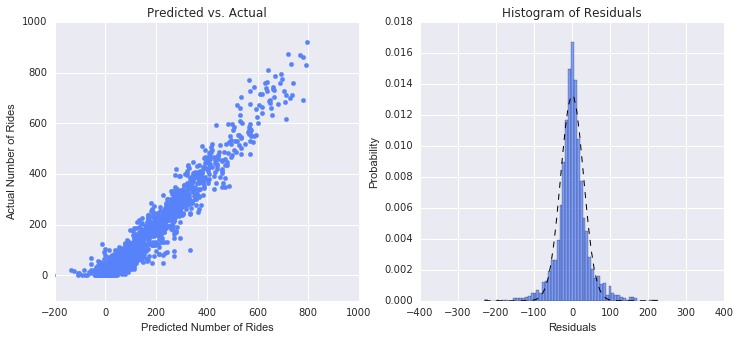

In [562]:
residuals = test_target - preds
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
ax = plt.gca()

# scatter plot of actual vs. predicted
ax1.scatter(preds, test_target, marker='o', color = '#5882FA')
ax1.set_xlim(-200, 1000)
ax1.set_ylim(-100, 1000)
ax1.set_xlabel('Predicted Number of Rides')
ax1.set_ylabel('Actual Number of Rides')
ax1.set_title('Predicted vs. Actual')

# histogram of residuals
n, bins, patches = plt.hist(residuals, bins=60, normed=1, facecolor='#5882FA', alpha=0.75)
mu, sigma = 0, 30                              # add a 'best fit' line
ax2.set_xlim(-400, 400)
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'k--', linewidth=1)

plt.xlabel('Residuals')
plt.ylabel('Probability')
plt.title('Histogram of Residuals')

plt.show()

# 5. Performance

The distribution of predicted daily rides produced by the random forest model follows the most similar pattern to the actual daily rides, confirming that the random forest model performs decently well and best among the three prediction algorithms in this study.

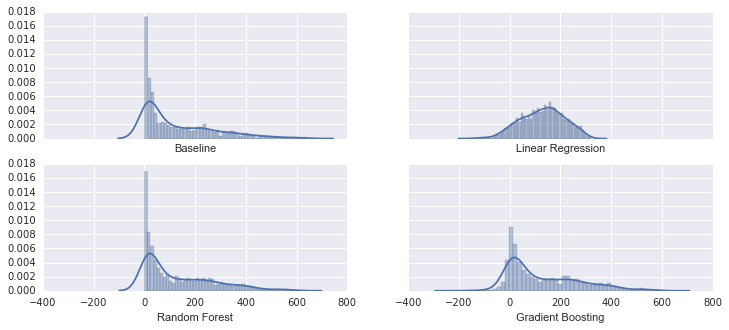

In [633]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(12,5)
ax1 = sns.distplot(test_target, axlabel='Baseline', ax=axes[0][0], bins=50)
ax2 = sns.distplot(l_preds, axlabel='Linear Regression', ax=axes[0][1], bins=50)
ax3 = sns.distplot(rf_preds, axlabel='Random Forest', ax=axes[1][0], bins=50)
ax4 = sns.distplot(gbm_preds, axlabel='Gradient Boosting', ax=axes[1][1], bins=50)
plt.show()